# This is a train for a yolov8n model to detect the weapon objects (knife and gun) in the images

Author: Zhyldyz Davydova



# Dataset Preparation



Upload the dataset_small.zip to your google drive

Mount to drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Install Ultralytics which has yolo packages

In [2]:
!pip install -U ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.3 MB/s eta 0:00:00


Unzip the dataset folder if not done before

In [12]:
from pathlib import Path
import zipfile

# ---- PATHS ----
PROJECT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/")
ZIP_PATH    = PROJECT_DIR / "weapon training.zip"   # change name if needed
EXTRACT_TO  = PROJECT_DIR / "weapon training"

# ---- EXTRACT ----
if not EXTRACT_TO.exists():
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_TO)
    print("Dataset extracted to:", EXTRACT_TO)
else:
    print("Dataset already exists at:", EXTRACT_TO)

Dataset already exists at: /content/drive/MyDrive/Colab Notebooks


In [13]:
import shutil
from pathlib import Path

base = Path("/content/drive/MyDrive/Colab Notebooks/weapon training")

inner = base / "weapon training"
if inner.exists():
    for item in inner.iterdir():
        shutil.move(str(item), base)
    inner.rmdir()

print(" Folder flattened")

Error: Destination path '/content/drive/MyDrive/Colab Notebooks/weapon training/data.yaml' already exists

# Model Training

Point to the data yaml file and initialise model output directories. Sapecify the yolo model and some parameters

In [15]:
from ultralytics import YOLO
from pathlib import Path
import torch, shutil

# ---- PATHS (CHANGE ONLY IF NEEDED) ----
PROJECT_DIR = Path("/content/drive/MyDrive/Colab Notebooks/weapon training")
DATA_YAML   = PROJECT_DIR / "data.yaml"

RUNS_DIR    = PROJECT_DIR / "runs/detect"
STABLE_DIR  = PROJECT_DIR / "models"
STABLE_BEST = STABLE_DIR / "best.pt"

STABLE_DIR.mkdir(parents=True, exist_ok=True)

# ---- TRAINING CONFIG (YOUR CHOICE) ----
MODEL  = "yolov8n.pt"
EPOCHS = 35
IMGSZ  = 1280
BATCH  = 16
LR0    = 0.001

DEVICE = 0 if torch.cuda.is_available() else "cpu"

print("Device:", "GPU" if DEVICE == 0 else "CPU")

Device: GPU


Configure the yaml to fit the Unix environemnt

Specify your path if not saved in the same directory


In [ ]:
from pathlib import Path
import yaml

DATA_YAML = Path("/content/drive/MyDrive/Colab Notebooks/weapon training/data.yaml")

cfg = {
    "train": "dataset_splitted/images/train",
    "val": "dataset_splitted/images/val",
    "test": "dataset_splitted/images/test",
    "nc": 2,
    "names": {
        0: "knife",
        1: "gun"
    }
}

with open(DATA_YAML, "w") as f:
    yaml.dump(cfg, f, sort_keys=False)

print("data.yaml fixed for Colab:")
print(DATA_YAML.read_text())

data.yaml fixed for Colab:
path: /dataset_splitted
train: images/train
val: images/val
test: images/test
nc: 2
names:
  0: knife
  1: gun



Actual Train of the model, changed the default optimizer from SDG to AdamW

In [ ]:
model = YOLO(MODEL)

model.train(
    data=str(DATA_YAML),
    epochs=EPOCHS,
    imgsz=IMGSZ,
    batch=BATCH,
    device=DEVICE,
    project=str(RUNS_DIR),
    name="hazard_fast",
    optimizer="AdamW",
    lr0=LR0,
    patience=5,
    workers=2,
    cache=True,
    save=True,
    plots=True,
    verbose=True,
)

# ---- Find and persist best.pt ----
candidates = sorted(RUNS_DIR.rglob("best.pt"), key=lambda p: p.stat().st_mtime)

if not candidates:
    raise RuntimeError("❌ Training finished but best.pt not found")

best = candidates[-1]
shutil.copy2(best, STABLE_BEST)

print("\n TRAINING COMPLETE")
print(" Best model saved permanently at:")
print(STABLE_BEST)

Ultralytics 8.4.18 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/weapon training/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=hazard_fast4, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, ove

# Evaluation

Evaluate the code on validation ant testing, including the per class evaluation




In [21]:
from ultralytics import YOLO

# -------- LOAD CHECKPOINT --------
if not STABLE_BEST.exists():
    raise FileNotFoundError(" best.pt not found in models/")

print("Using checkpoint:", STABLE_BEST)
model = YOLO(str(STABLE_BEST))

# -------- TEST / EVALUATE --------
for split in ["val", "test"]:
    print(f"\n Evaluating on {split} set")

    r = model.val(
        data=str(DATA_YAML),
        split=split,
        imgsz=IMGSZ,
        conf=0.25,
        iou=0.50,
        plots=True,
        verbose=True,
        project=str(RUNS_DIR),
        name=f"eval_{split}",
    )

    # Metrics
    precision = float(r.box.mp)
    recall    = float(r.box.mr)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)

    print(f"\n{'='*45}")
    print(f" {split.upper()} RESULTS")
    print(f"{'='*45}")
    print(f" mAP@50     : {r.box.map50:.4f}")
    print(f" mAP@50-95  : {r.box.map:.4f}")
    print(f" Precision  : {precision:.4f}")
    print(f" Recall     : {recall:.4f}")
    print(f" F1-score   : {f1:.4f}")

    # Per-class AP@50
    if r.box.ap50 is not None:
        print("\n Per-class mAP@50:")
        for cls, ap in zip(NAMES, r.box.ap50):
            print(f"  {cls:6}: {float(ap):.4f}")

    print("\n Results saved to:")
    print(RUNS_DIR / f"eval_{split}")

Using checkpoint: /content/drive/MyDrive/Colab Notebooks/weapon training/models/best.pt

 Evaluating on val set
Ultralytics 8.4.18 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Model summary (fused): 73 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 27.3±23.2 MB/s, size: 51.9 KB)
val: Scanning /content/drive/MyDrive/Colab Notebooks/weapon training/dataset_splitted/labels/val... 415 images, 14 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 429/429 2.3it/s 3:10
val: New cache created: /content/drive/MyDrive/Colab Notebooks/weapon training/dataset_splitted/labels/val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 4.7it/s 5.7s
                   all        429        466      0.687      0.771      0.748      0.519
                 knife        214        236      0.607      0.686      0.624      0.296
                   gun        201        230    

Confusion Matrix

TEST confusion matrix: /content/drive/MyDrive/Colab Notebooks/weapon training/runs/detect/eval_test3/confusion_matrix.png


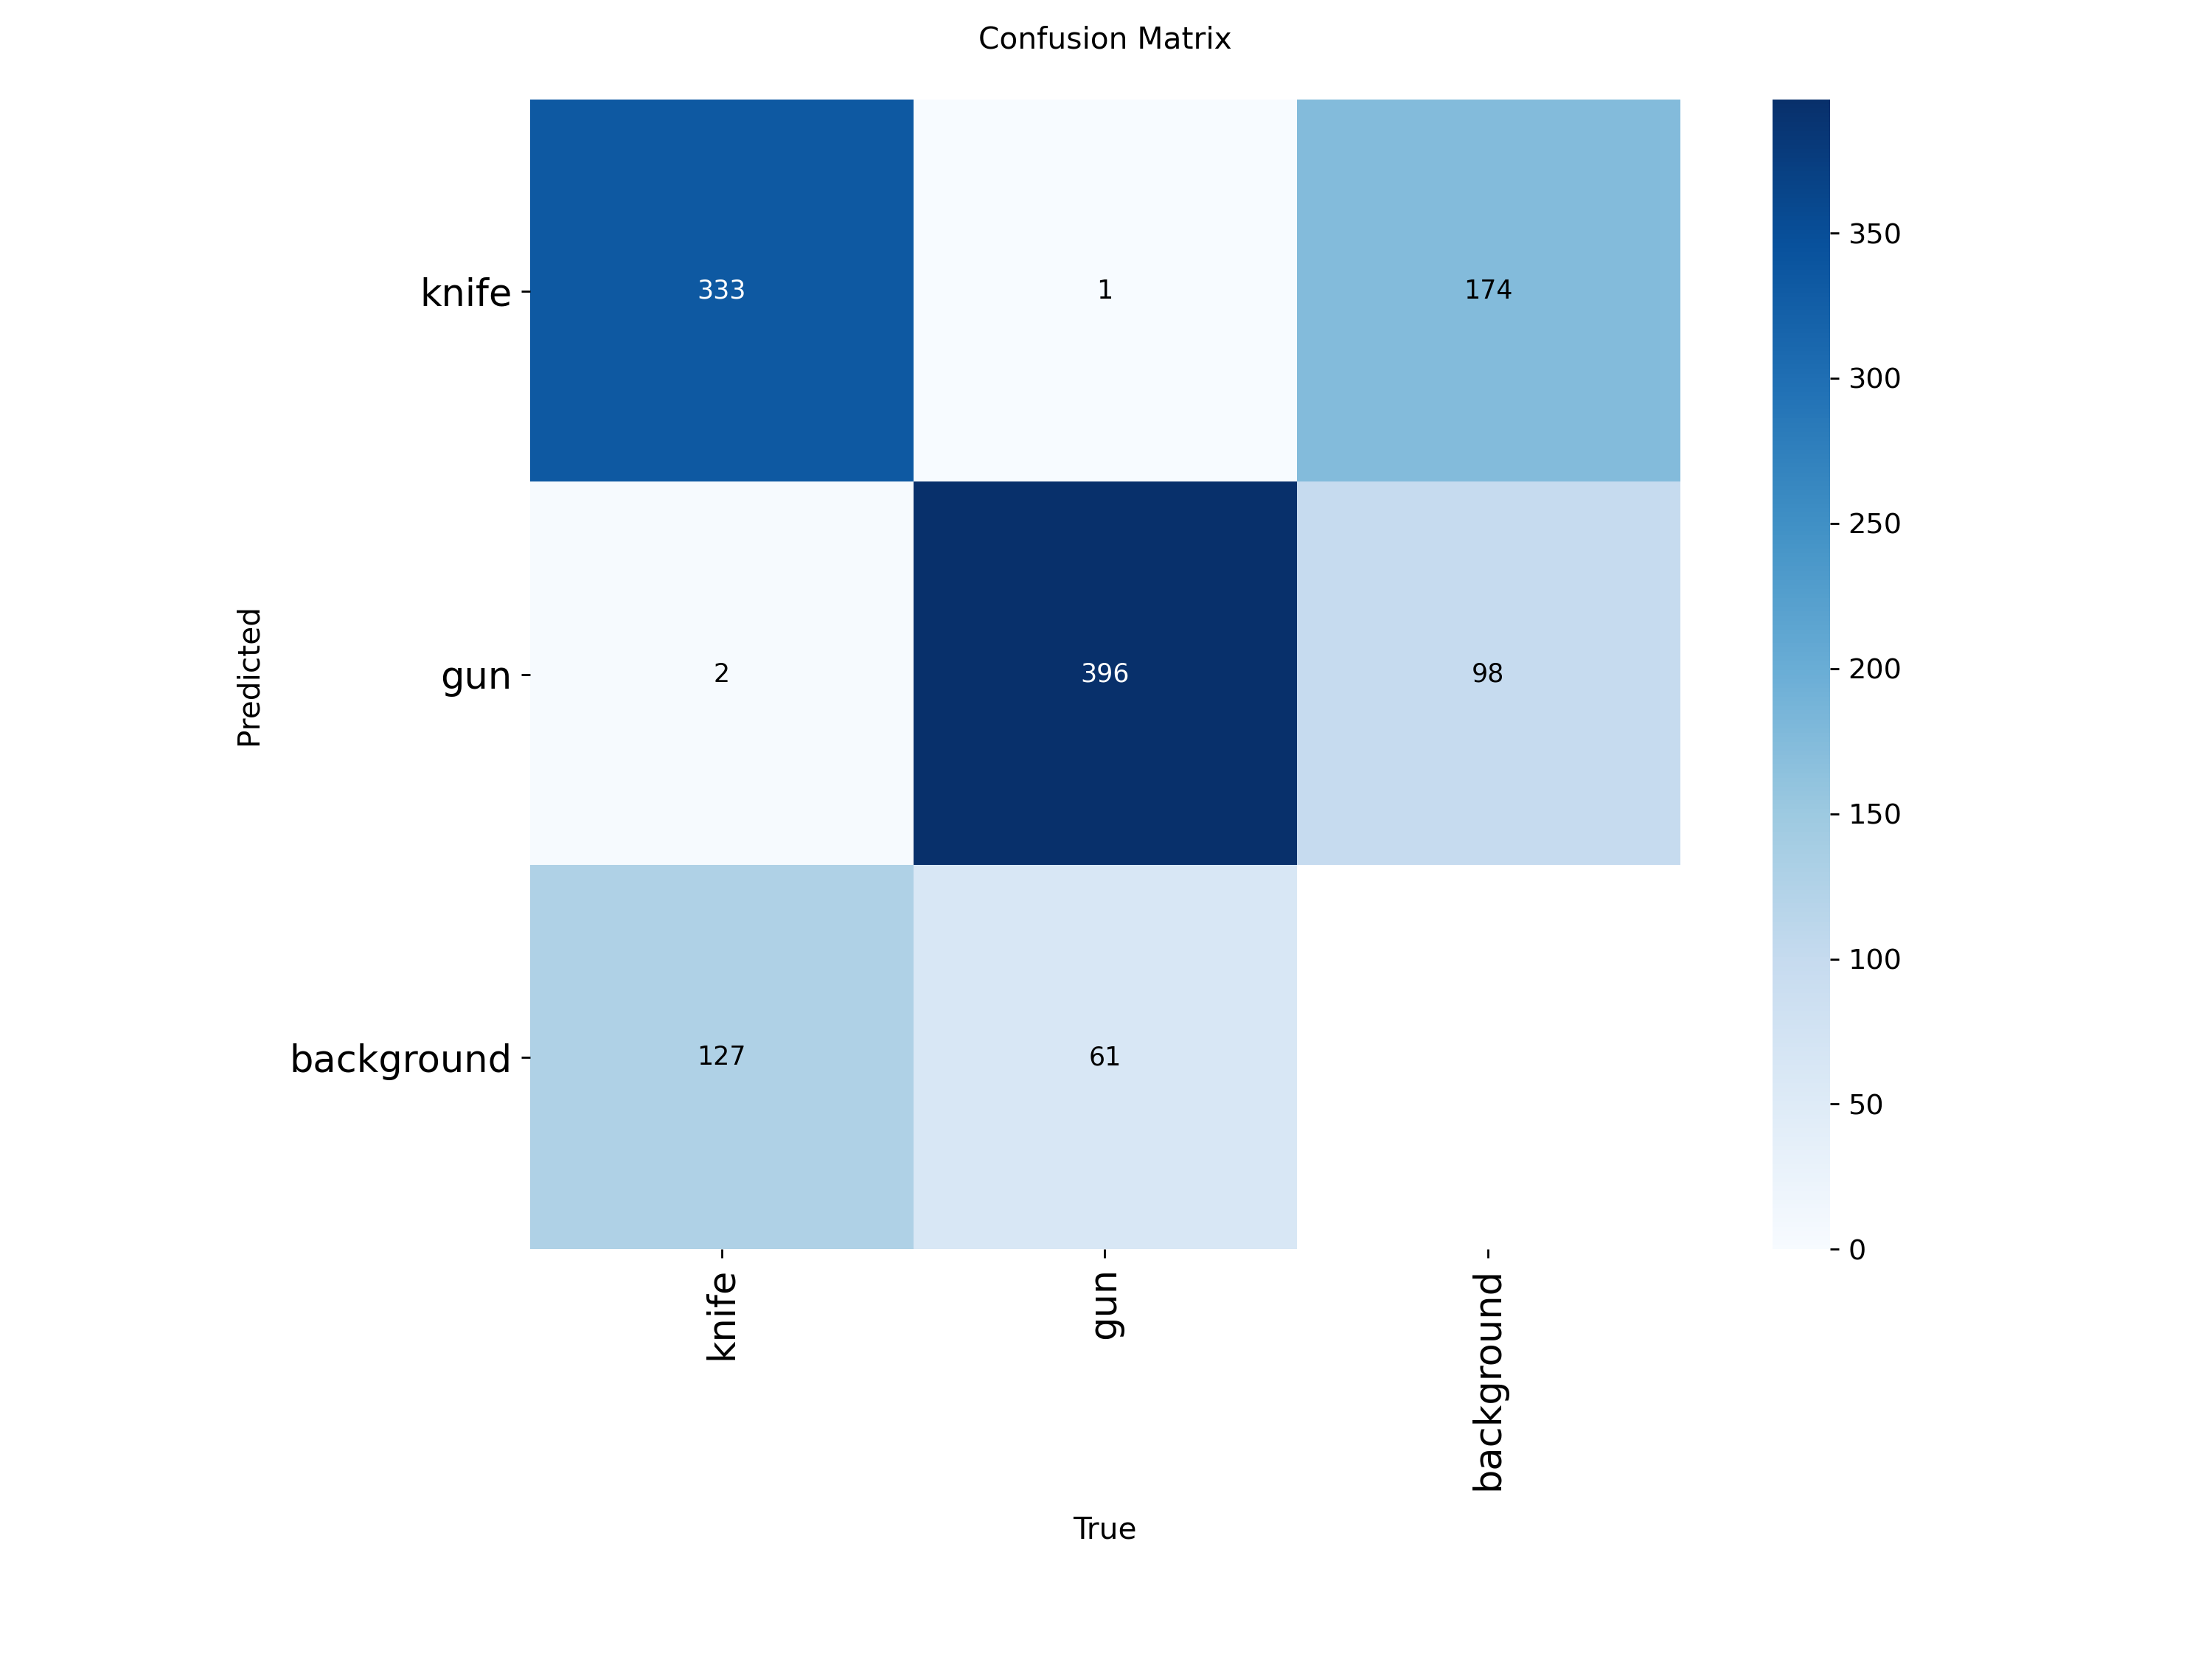

In [22]:
from pathlib import Path
from PIL import Image

RUNS_DIR = Path("/content/drive/MyDrive/Colab Notebooks/weapon training/runs/detect")

# latest eval_test* folder
eval_test_dirs = sorted([d for d in RUNS_DIR.glob("eval_test*") if d.is_dir()],
                        key=lambda p: p.stat().st_mtime)
if not eval_test_dirs:
    raise FileNotFoundError("No eval_test* folder found. (Did you run evaluation with plots=True?)")

EVAL_TEST_DIR = eval_test_dirs[-1]

cm_path = EVAL_TEST_DIR / "confusion_matrix.png"
if not cm_path.exists():
    cm_path = EVAL_TEST_DIR / "confusion_matrix_normalized.png"

print("TEST confusion matrix:", cm_path)
display(Image.open(cm_path))

Precision Recall Curves

Using training log: /content/drive/MyDrive/Colab Notebooks/weapon training/runs/detect/hazard_fast4/results.csv


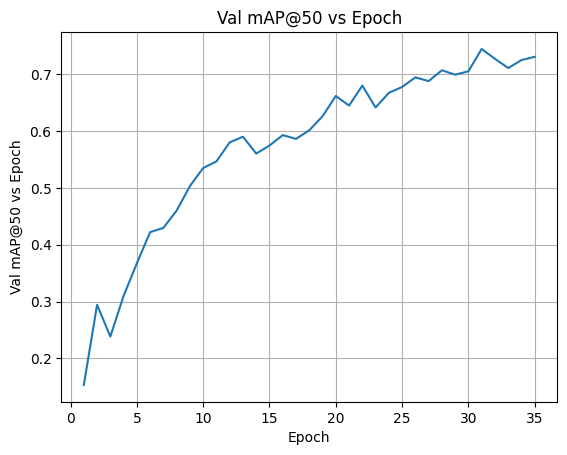

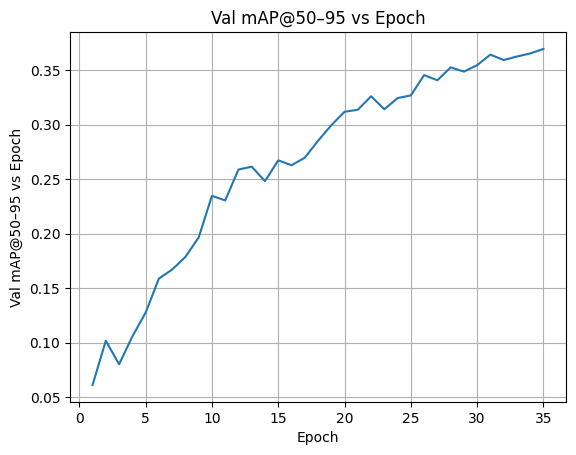

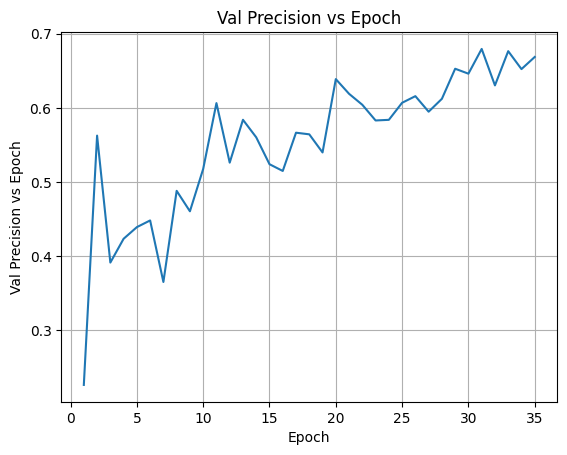

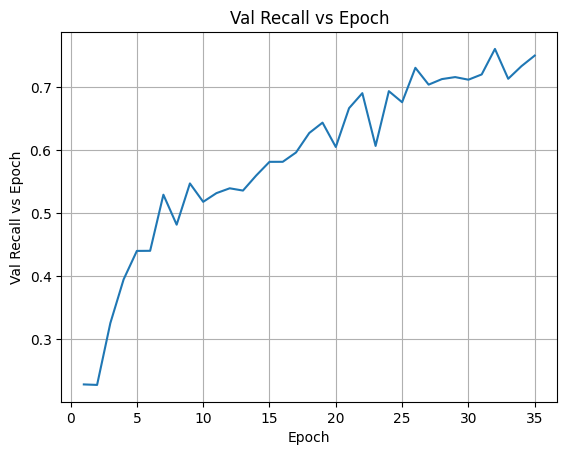

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

RUNS_DIR = Path("/content/drive/MyDrive/Colab Notebooks/weapon training/runs/detect")

# latest hazard_fast* folder (training run)
train_dirs = sorted([d for d in RUNS_DIR.glob("hazard_fast*") if d.is_dir()],
                    key=lambda p: p.stat().st_mtime)
if not train_dirs:
    raise FileNotFoundError("No hazard_fast* training run folder found.")

TRAIN_DIR = train_dirs[-1]
csv_path = TRAIN_DIR / "results.csv"
if not csv_path.exists():
    raise FileNotFoundError("results.csv not found in: " + str(TRAIN_DIR))

print("Using training log:", csv_path)
df = pd.read_csv(csv_path)

# Column names in Ultralytics results.csv can vary slightly by version
epoch_col = "epoch" if "epoch" in df.columns else df.columns[0]

def plot_if_exists(colname, title):
    if colname in df.columns:
        plt.figure()
        plt.plot(df[epoch_col], df[colname])
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel(title)
        plt.grid(True)
        plt.show()

plot_if_exists("metrics/mAP50(B)",     "Val mAP@50 vs Epoch")
plot_if_exists("metrics/mAP50-95(B)",  "Val mAP@50–95 vs Epoch")
plot_if_exists("metrics/precision(B)", "Val Precision vs Epoch")
plot_if_exists("metrics/recall(B)",    "Val Recall vs Epoch")

# Demo

You can also use the demo version from github repository.
Upload an image that you want to test

In [25]:
from ultralytics import YOLO
from pathlib import Path
from google.colab import files
from PIL import Image
import pandas as pd

# ---- LOAD YOUR TRAINED MODEL ----
MODEL_PATH = STABLE_BEST  # uses your permanent best.pt path
demo_model = YOLO(str(MODEL_PATH))

# ---- UPLOAD IMAGE ----
uploaded = files.upload()  # choose an image from your computer
img_path = Path(next(iter(uploaded.keys())))  # first uploaded file

print("Uploaded:", img_path)

# ---- RUN INFERENCE ----
results = demo_model.predict(
    source=str(img_path),
    imgsz=IMGSZ,        # same as training for consistency
    conf=0.25,          # adjust threshold if needed
    iou=0.45,           # NMS IoU
    save=True,          # saves annotated result in runs/detect/predict*
    verbose=False
)

r = results[0]

# ---- SHOW ANNOTATED IMAGE (IN NOTEBOOK) ----
annotated = r.plot()  # numpy array with boxes drawn
Image.fromarray(annotated)

# ---- PRINT + TABLE OF DETECTIONS ----
if r.boxes is None or len(r.boxes) == 0:
    print("\n No objects detected above the confidence threshold.")
else:
    names = r.names
    boxes = r.boxes

    df = pd.DataFrame({
        "class_id": boxes.cls.cpu().numpy().astype(int),
        "class": [names[int(c)] for c in boxes.cls.cpu().numpy()],
        "conf": boxes.conf.cpu().numpy(),
        "x1": boxes.xyxy[:, 0].cpu().numpy(),
        "y1": boxes.xyxy[:, 1].cpu().numpy(),
        "x2": boxes.xyxy[:, 2].cpu().numpy(),
        "y2": boxes.xyxy[:, 3].cpu().numpy(),
    }).sort_values("conf", ascending=False).reset_index(drop=True)

    print("\n Detections:")
    display(df)

Saving Screenshot 2026-02-27 130428.png to Screenshot 2026-02-27 130428 (1).png
Uploaded: Screenshot 2026-02-27 130428 (1).png
Results saved to /content/runs/detect/predict3

 Detections:


,class_id,class,conf,x1,y1,x2,y2
0,0,knife,0.603279,582.657043,331.861847,726.244202,427.335663


Display the weapon location

#1: knife | conf=0.603


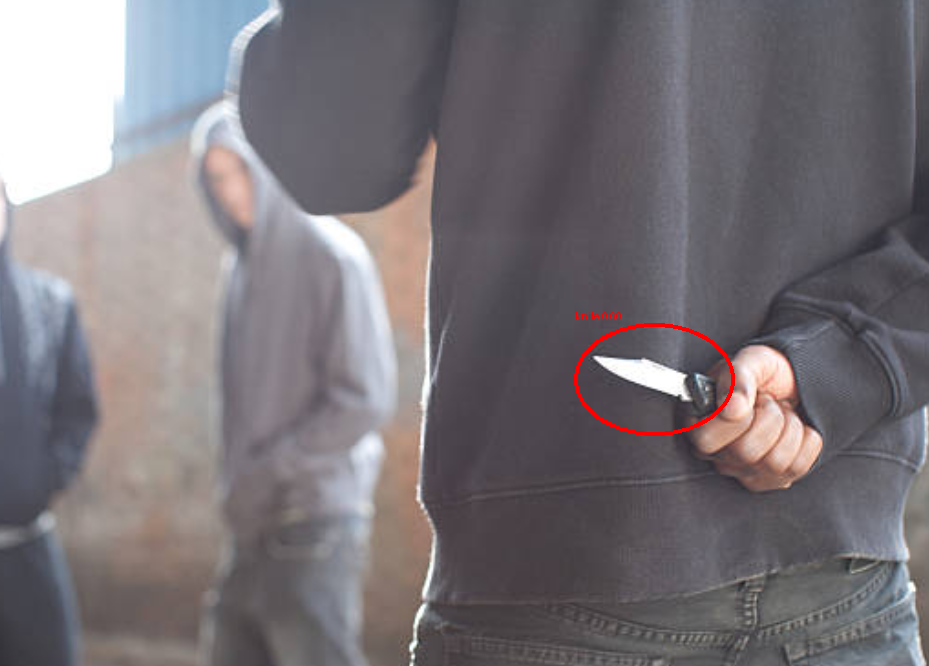

In [26]:
from PIL import Image, ImageDraw

# Open original image
img = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(img)

if r.boxes is None or len(r.boxes) == 0:
    print(" No detections")
else:
    for i in range(len(r.boxes)):
        # Bounding box
        x1, y1, x2, y2 = r.boxes.xyxy[i].cpu().numpy()
        conf = float(r.boxes.conf[i].cpu().numpy())
        cls_id = int(r.boxes.cls[i].cpu().numpy())
        cls_name = r.names[cls_id]

        # Expand box slightly so circle doesn't hug object too tightly
        pad = 8
        x1, y1 = max(0, x1 - pad), max(0, y1 - pad)
        x2, y2 = x2 + pad, y2 + pad

        # Draw ellipse (circle-like) around the object
        draw.ellipse(
            [(x1, y1), (x2, y2)],
            outline="red",
            width=4
        )

        # Optional label above the circle
        label = f"{cls_name} {conf:.2f}"
        draw.text((x1, max(0, y1 - 14)), label, fill="red")

        print(f"#{i+1}: {cls_name} | conf={conf:.3f}")

# Show final image
display(img)